This example notebook shows how to run the SRI MAPER code with a ResNet backbone.

In [1]:
from sri_maper.src.utils import build_hydra_config_notebook, print_config_tree
from sri_maper.src.train import train
from sri_maper.src.test import test
from sri_maper.src.map import build_map
from torch import set_float32_matmul_precision

set_float32_matmul_precision('medium') # reduces floating point precision for computational efficiency

First we'll define the "experiment config". An experiment config (short for configuration) defines all changable parameters for the experiment. This includes data parameters (e.g. raster stack to use), model parameters (e.g. backbone architecture), training parameters (e.g. GPU vs CPU training), mapping parameters (e.g. number of monte-carlo samples), and others. [Hydra](https://hydra.cc/) is the open-soure hierarchical experiment configuration library we use to implement our experiment configuration. Please supplement our instructions / guidance with [Hydra's documentation](https://hydra.cc/docs/intro/).

As an example, below we load the config for the national-scale Magmatic Nickel challeng (MaNiAC) presented at Hackathon 2.

In [2]:
train_cfg = build_hydra_config_notebook(
    overrides=[
        "experiment=exp_maniac_resnet_l22_uscont",
        "logger=csv", # wandb logger has issues in notebooks
        "trainer=gpu" # ********* COMMENT IF YOU DON'T HAVE A GPU *********
        #"trainer=cpu" # ********* UNCOMMENT IF YOU DON'T HAVE A GPU *********
    ]
)
print_config_tree(train_cfg)

CONFIG
├── data
│   └── _target_: sri_maper.src.data.tiff_datamodule.TIFFDataModule                                                
│       tif_dir: ${paths.data_dir}/H3/MaNiAC                                                                       
│       window_size: 5                                                                                             
│       multiplier: 20                                                                                             
│       downsample: true                                                                                           
│       oversample: true                                                                                           
│       likely_neg_range:                                                                                          
│       - 0.4                                                                                                      
│       - 0.7                                                                                                      
│       frac_train_split: 0.5                                                                                      
│       batch_size: 32                                                                                             
│       num_workers: 12                                                                                            
│       pin_memory: false                                                                                          
│       seed: ${seed}                                                                                              
│       log_path: ${paths.output_dir}                                                                              
│                                                                                                                  
├── model
│   └── _target_: sri_maper.src.models.cma_module.CMALitModule                                                     
│       optimizer:                                                                                                 
│         _target_: torch.optim.AdamW                                                                              
│         _partial_: true                                                                                          
│         lr: 0.001                                                                                                
│         weight_decay: 0.01                                                                                       
│       scheduler:                                                                                                 
│         _target_: torch.optim.lr_scheduler.ReduceLROnPlateau                                                     
│         _partial_: true                                                                                          
│         mode: min                                                                                                
│         factor: 0.1                                                                                              
│         patience: 10                                                                                             
│       net:                                                                                                       
│         _target_: sri_maper.src.models.resnet.ResNet                                                             
│         num_input_channels: 14                                                                                   
│         num_output_classes: 1                                                                                    
│         dropout_rate: 0.5                                                                                        
│       compile: false                                                                                             
│       gain: 1.0             

The config above is for MaNiAC; however, changing the config for another deposit that exists in our repo is as easy as changing a single paramter. Simply modify the "experiment" variable above with the overrides to a different ResNet [experiment](../configs/experiment/). Current ResNet experiment configs available are:
* exp_maniac_resnet_l22_uscont
* exp_mvt_resnet_l22_uscont
* exp_w_resnet_l22_uscont

Now we can use the generated config file to run the experiment. We pass this config file to the [train task](../src/train.py), which returns metrics and objects created during the run.

In [3]:
train_metrics, train_objs = train(train_cfg)

Global seed set to 1234
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.64it/s]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
Using 16bit None Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     ┃ Name                               ┃ Type                   ┃ Params ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0   │ net                                │ ResNet                 │ 11.2 M │
│ 1   │ net.backbone                       │ FeatureListNet         │ 11.2 M │
│ 2   │ net.backbone.conv1                 │ Conv2d                 │ 43.9 K │
│ 3   │ net.backbone.bn1                   │ BatchNorm2d            │    128 │
│ 4   │ net.backbone.act1                  │ ReLU                   │      0 │
│ 5   │ net.backbone.maxpool               │ MaxPool2d              │      0 │
│ 6   │ net.backbone.layer1                │ Sequential             │  147 K │
│ 7   │ net.backbone.layer1.0              │ BasicBlock             │ 74.0 K │
│ 8   │ net.backbone.layer1.0.conv1        │ Conv2d                 │ 36.9 K │
│ 9   │ net.backbone.layer1.0.bn1          │ BatchNorm2d            │    128 │
│ 10  │ net.backbone.layer1.0.drop_block   │ Identity               │      0 │
│ 11  │ net.backbone.layer1.0.act1         │ ReLU                   │      0 │
│ 12  │ net.backbone.layer1.0.aa           │ Identity               │      0 │
│ 13  │ net.backbone.layer1.0.conv2        │ Conv2d                 │ 36.9 K │
│ 14  │ net.backbone.layer1.0.bn2          │ BatchNorm2d            │    128 │
│ 15  │ net.backbone.layer1.0.act2         │ ReLU                   │      0 │
│ 16  │ net.backbone.layer1.1              │ BasicBlock             │ 74.0 K │
│ 17  │ net.backbone.layer1.1.conv1        │ Conv2d                 │ 36.9 K │
│ 18  │ net.backbone.layer1.1.bn1          │ BatchNorm2d            │    128 │
│ 19  │ net.backbone.layer1.1.drop_block   │ Identity               │      0 │
│ 20  │ net.backbone.layer1.1.act1         │ ReLU                   │      0 │
│ 21  │ net.backbone.layer1.1.aa           │ Identity               │      0 │
│ 22  │ net.backbone.layer1.1.conv2        │ Conv2d                 │ 36.9 K │
│ 23  │ net.backbone.layer1.1.bn2          │ BatchNorm2d            │    128 │
│ 24  │ net.backbone.layer1.1.act2         │ ReLU                   │      0 │
│ 25  │ net.backbone.layer2                │ Sequential             │  525 K │
│ 26  │ net.backbone.layer2.0              │ BasicBlock             │  230 K │
│ 27  │ net.backbone.layer2.0.conv1        │ Conv2d                 │ 73.7 K │
│ 28  │ net.backbone.layer2.0.bn1          │ BatchNorm2d            │    256 │
│ 29  │ net.backbone.layer2.0.drop_block   │ Identity               │      0 │
│ 30  │ net.backbone.layer2.0.act1         │ ReLU                   │      0 │
│ 31  │ net.backbone.layer2.0.aa           │ Identity               │      0 │
│ 32  │ net.backbone.layer2.0.conv2        │ Conv2d                 │  147 K │
│ 33  │ net.backbone.layer2.0.bn2          │ BatchNorm2d            │    256 │
│ 34  │ net.backbone.layer2.0.act2         │ ReLU                   │      0 │
│ 35  │ net.backbone.layer2.0.downsample   │ Sequential             │  8.4 K │
│ 36  │ net.backbone.layer2.0.downsample.0 │ Conv2d                 │  8.2 K │
│ 37  │ net.backbone.layer2.0.downsample.1 │ BatchNorm2d            │    256 │
│ 38  │ net.backbone.layer2.1              │ BasicBlock             │  295 K │
│ 39  │ net.backbone.layer2.1.conv1        │ Conv2d                 │  147 K │
│ 40  │ net.backbone.layer2.1.bn1          │ BatchNorm2d            │    256 │
│ 41  │ net.backbone.layer2.1.drop_block   │ Identity               │      0 │
│ 42  │ net.backbone.layer2.1.act1         │ ReLU                   │      0 │
│ 43  │ net.backbone.layer2.1.aa           │ Identity               │      0 │
│ 44  │ net.backbone.layer2.1.conv2        │ Conv2d                 │  147 K │
│ 45  │ net.backbone.layer2.1.bn2          │ BatchNorm2d            │    256 │
│ 46  │ net.backbone.layer2.1.act2         │ ReLU                   │      0 │
│ 47  │ net.backbone.layer3                │ Seque

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 22

Output()

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in 
targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Output()

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in 
targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9721361994743347     │
│         test/auc          │    0.9134539365768433     │
│        test/auprc         │    0.7344998717308044     │
│       test/bal_acc        │    0.8168895840644836     │
│          test/f1          │    0.6896551847457886     │
│         test/loss         │    0.38509172201156616    │
│         test/mcc          │    0.6769072413444519     │
│        test/prob1         │    0.05263157933950424    │
│        test/recall        │    0.7096773982048035     │
└───────────────────────────┴───────────────────────────┘

If training completed successfully, you will see the outputs of all the logging running when training above. By carefully reading through the logs above, you will find where the model checkpoints, logs, and other generated files are stored. These can also be accessed using return values of train above.

For example, let's test the trained model again using the [test task](../src/test.py). Note - testing is optionally included in the training above and can be disabled by modifying the experiment config.

In [4]:
train_cfg.ckpt_path = train_objs["trainer"].checkpoint_callback.best_model_path # required for test
test_metrics, test_objs = test(train_cfg)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.70it/s]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/opt/conda/lib/python3.10/site-packages/pytorch_lightni

Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9721361994743347     │
│         test/auc          │    0.9134539365768433     │
│        test/auprc         │    0.7344998717308044     │
│       test/bal_acc        │    0.8168895840644836     │
│          test/f1          │    0.6896551847457886     │
│         test/loss         │    0.38509172201156616    │
│         test/mcc          │    0.6769072413444519     │
│        test/prob1         │    0.05263157933950424    │
│        test/recall        │    0.7096773982048035     │
└───────────────────────────┴───────────────────────────┘

You'll notice the repeated testing shows our experiments / testing are repeatable as all metrics match up to 4 significant figures.

Note, `train`, `test`, and `build_map` (below) all can run individually and with different configs. Below we'll build a map and use a different config to do so, by manipulating the existing one. Below we've elected to use a larger batch size during mapping.

In [5]:
train_cfg.data.batch_size=128
maniac_maps, _ = build_map(train_cfg)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.93it/s]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

Optionally, we can directly plot these produced maps. For example, below we plot the likelihood. Note - the raw output maps should be re-clipped using the study region bounds (e.g. a vector file) in QGIS.

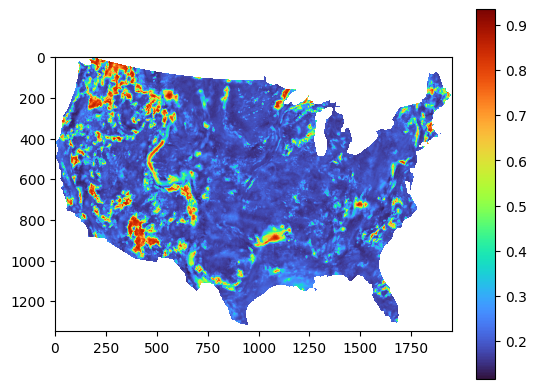

In [6]:
import rasterio
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path

with rasterio.open(maniac_maps[0], "r") as likelihood_raster:
    likelihood_data = likelihood_raster.read(1)
plt.imshow(likelihood_data, cmap="turbo")
plt.colorbar()
plt.show()

NOTE - These maps, runtimes, and metrics differ from the report maps, runtimes, and metrics generated by the **preferred method using the CLI**. The difference is due to the difference in hardware configuration (i.e. multi-GPU vs single-GPU/CPU)